![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/BG_NOISE_REMOVER.ipynb)

# Remove background noise from scanned documents

To run this yourself, you will need to upload your **Spark OCR** license keys to the notebook. Otherwise, you can look at the example outputs at the bottom of the notebook. To upload license keys, open the file explorer on the left side of the screen and upload `workshop_license_keys.json` to the folder that opens.

For more in-depth tutorials: https://github.com/JohnSnowLabs/spark-ocr-workshop/tree/master/jupyter

## 1. Colab Setup

Install correct version of Pillow and Restart runtime

In [ ]:
# Install correct Pillow version
import PIL
if PIL.__version__  != '6.2.1':
  print ('Installing correct version of Pillow. Kernel will restart automatically')
  !pip install --upgrade pillow==6.2.1
  # hard restart runtime
  import os
  os.kill(os.getpid(), 9)
else:
  print ('Correct Pillow detected')

Correct Pillow detected


Read licence key

In [ ]:
import os
import json

with open('workshop_license_keys.json') as f:
    license_keys = json.load(f)

print (license_keys.keys())

secret = license_keys['JSL_OCR_SECRET']
os.environ['SPARK_OCR_LICENSE'] = license_keys['SPARK_OCR_LICENSE']
os.environ['JSL_OCR_LICENSE'] = license_keys['SPARK_OCR_LICENSE']
version = secret.split("-")[0]
print ('Spark OCR Version:', version)

dict_keys(['JSL_OCR_SECRET', 'SPARK_OCR_LICENSE'])
Spark OCR Version: 1.5.0


Install Dependencies

In [ ]:
# Install Java
!apt-get update
!apt-get install -y openjdk-8-jdk
!java -version

# Install pyspark, SparkOCR, and SparkNLP
!pip install --ignore-installed -q pyspark==2.4.4
# Insall Spark Ocr from pypi using secret
!python -m pip install --upgrade spark-ocr==$version  --extra-index-url https://pypi.johnsnowlabs.com/$secret
# or install from local path
# %pip install --user ../../python/dist/spark-ocr-[version].tar.gz
!pip install --ignore-installed -q spark-nlp==2.5.2

Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import os

#Pyspark Imports
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

# Necessary imports from Spark OCR library
from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, to_pil_image
from sparkocr.metrics import score
import pkg_resources

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]


Start Spark Session

In [ ]:
spark = start(secret=secret)
spark

## 2. Read image with noised background

In [ ]:
import pkg_resources
imagePath = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/noised.png')
image_df = spark.read.format("binaryFile").load(imagePath).cache()
# If you want to load your own image simple mention the image path while loading
# Example: image_df = spark.read.format("binaryFile").load("image.jpg").cache()
image_df.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/usr/local/l...|2020-08-10 09:00:52|430295|[89 50 4E 47 0D 0...|
+--------------------+-------------------+------+--------------------+



## 3. Construct the OCR pipeline

In [ ]:
# Read binary as image
binary_to_image = BinaryToImage()
binary_to_image.setInputCol("content")
binary_to_image.setOutputCol("image")

# Scale image
scaler = ImageScaler()
scaler.setInputCol("image")
scaler.setOutputCol("scaled_image")
scaler.setScaleFactor(2.0)

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()
binarizer.setInputCol("scaled_image")
binarizer.setOutputCol("binarized_image")
binarizer.setBlockSize(91)
binarizer.setOffset(60)

# Apply morphology opening
opening = ImageMorphologyOperation()
opening.setKernelShape(KernelShape.SQUARE)
opening.setOperation(MorphologyOperationType.OPENING)
opening.setKernelSize(2)
opening.setInputCol("binarized_image")
opening.setOutputCol("opening_image")

# Remove small objects
remove_objects = ImageRemoveObjects()
remove_objects.setInputCol("opening_image")
remove_objects.setOutputCol("corrected_image")
remove_objects.setMinSizeFont(30)

# Run OCR for each region
ocr = ImageToText()
ocr.setInputCol("corrected_image")
ocr.setOutputCol("text")
ocr.setConfidenceThreshold(75)
ocr.setPageSegMode(PageSegmentationMode.SINGLE_BLOCK)
ocr.setIgnoreResolution(False)


# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    scaler,
    binarizer,
    opening,
    remove_objects,
    ocr
])

## 4. Run OCR pipeline

In [ ]:
result = pipeline.transform(image_df).cache()

## 5. Visualize Results

Display result dataframe

In [ ]:
result.select("text", "confidence").show()

+--------------------+-----------------+
|                text|       confidence|
+--------------------+-----------------+
|"Sur la base de l...|86.88619232177734|
+--------------------+-----------------+



Display detected min font size

In [ ]:
positions = result.select("positions").head().positions
mappings = [ mapping.fontSize for pos in positions for mapping in pos.mapping ]
print(min(mappings))

36


Display full text

In [ ]:
print("\n".join([row.text for row in result.select("text").collect()]))

"Sur la base de la grande statue de Zeus, 4 Olympie, Phidias avait
représenté les Douze Dieux. Entre le Soleil (Hélios) et la Lune (Seléné)
les douze divinités, groupées deux a deux, s’ordonnaient en six couples :
vn dieu-une déesse. Au centre de la frise, en surnombre, les deux divini-
tés: Féminine et masculine) qui président aux unions: Aphrodite et
Bros”, Dans cette série de huit couples divins, il en est un qui fait pro-
‘bl&ine : Hermés-Hestia. Pourquoi les apparier ? Rien dans leur généalo-
" gie ni dans leur légende qui puisse justifier cette association. Ils ne sont
‘pas mari et femme (comme Zeus-Héra, Poséidon-Amphitrite, Héphaistos-
‘ Charis), ni frére et sceur (comme Apollon-Artémis, Hélios-Séléné), ni
' mere et fils (comme Aphrodite-Eros), ni protectrice et protégé (comme
Athéna-Héraclés). Quel lien unissait donc, dans l’esprit de Phidias, un
dieu et une déesse qui semblent étrangers l’un 4 l’autre ? On ne saurait
‘alléguer une fantaisie personnelle du sculpteur. Quand il 

Display image for each stage

Original: file:/usr/local/lib/python3.6/dist-packages/sparkocr/resources/ocr/images/noised.png
Image:
        origin: file:/usr/local/lib/python3.6/dist-packages/sparkocr/resources/ocr/images/noised.png 
        width: 1312
        height: 948
        mode: 10


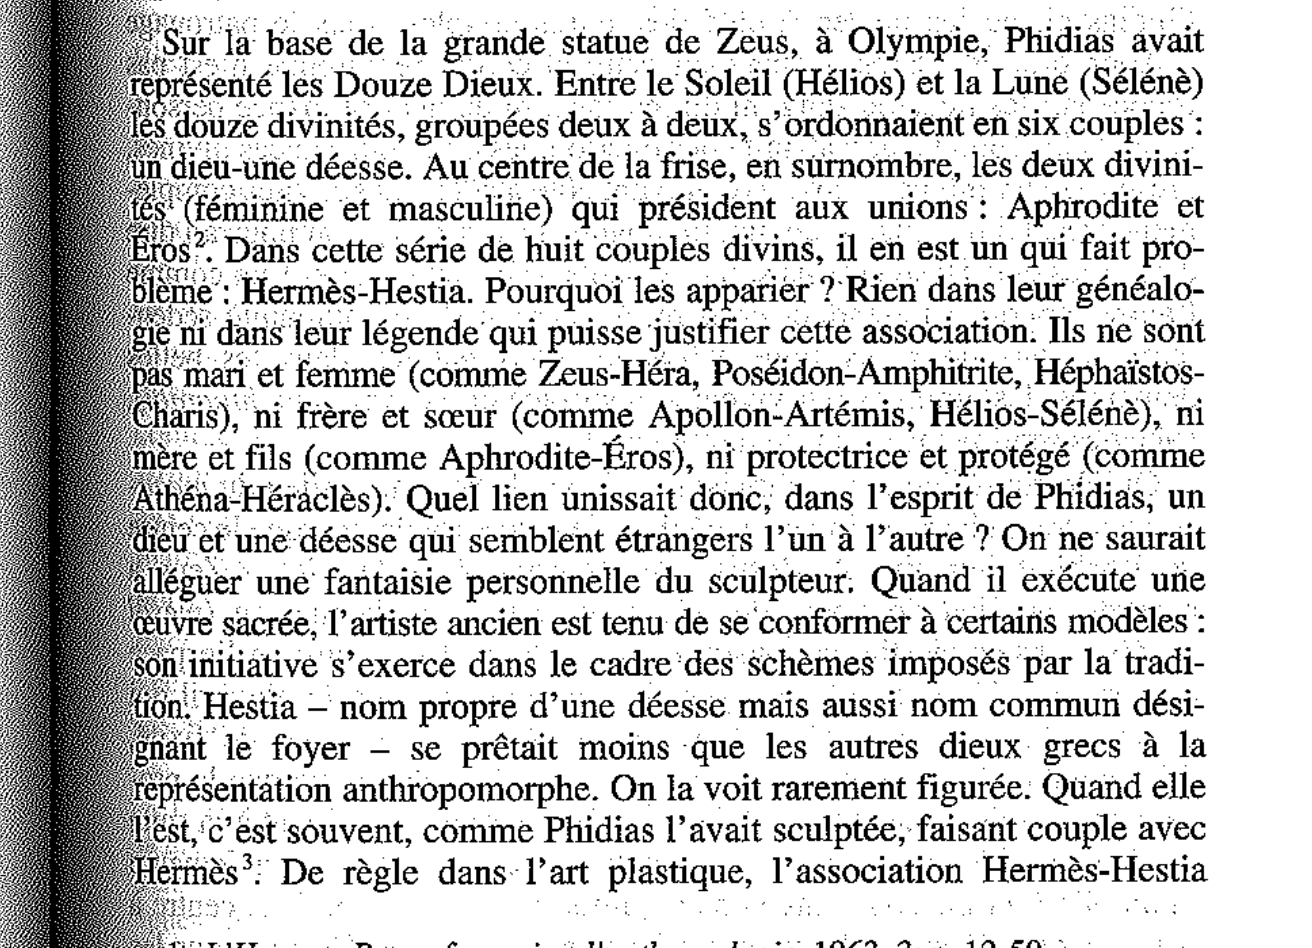

Binarized: file:/usr/local/lib/python3.6/dist-packages/sparkocr/resources/ocr/images/noised.png
Image:
        origin: file:/usr/local/lib/python3.6/dist-packages/sparkocr/resources/ocr/images/noised.png 
        width: 2624
        height: 1896
        mode: 10


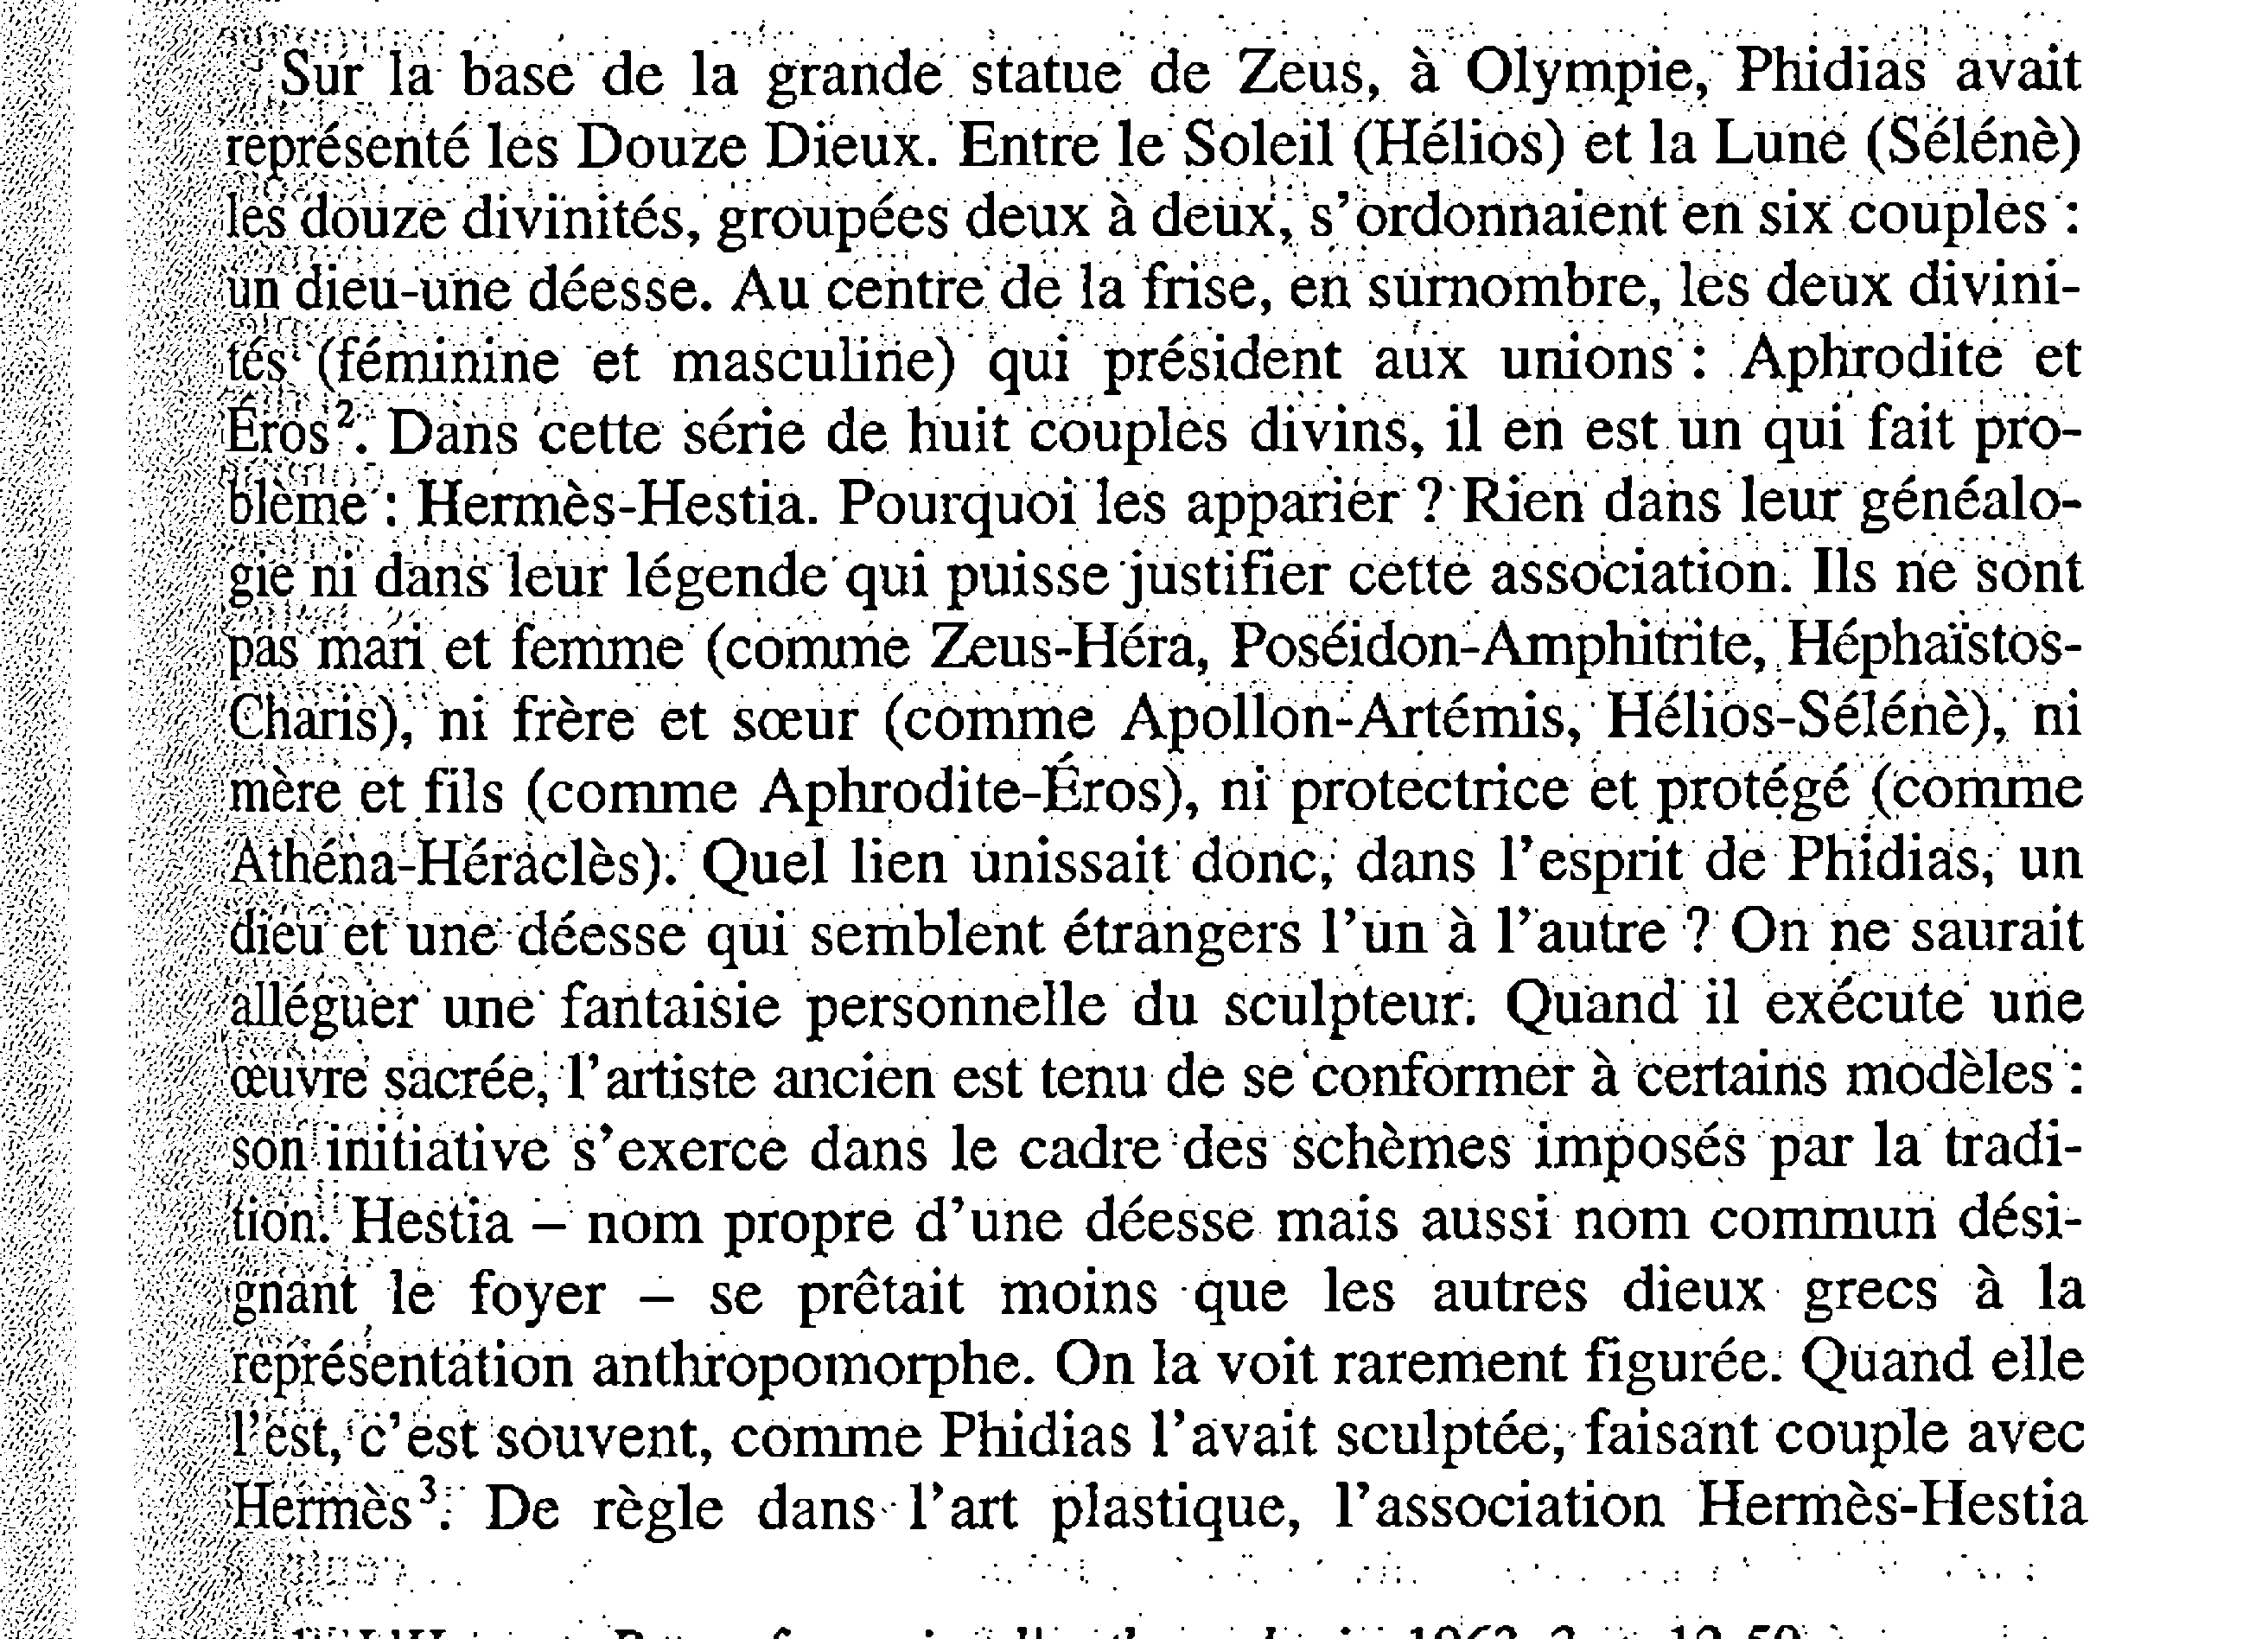

Morphology opening: file:/usr/local/lib/python3.6/dist-packages/sparkocr/resources/ocr/images/noised.png
Image:
        origin: file:/usr/local/lib/python3.6/dist-packages/sparkocr/resources/ocr/images/noised.png 
        width: 2624
        height: 1896
        mode: 10


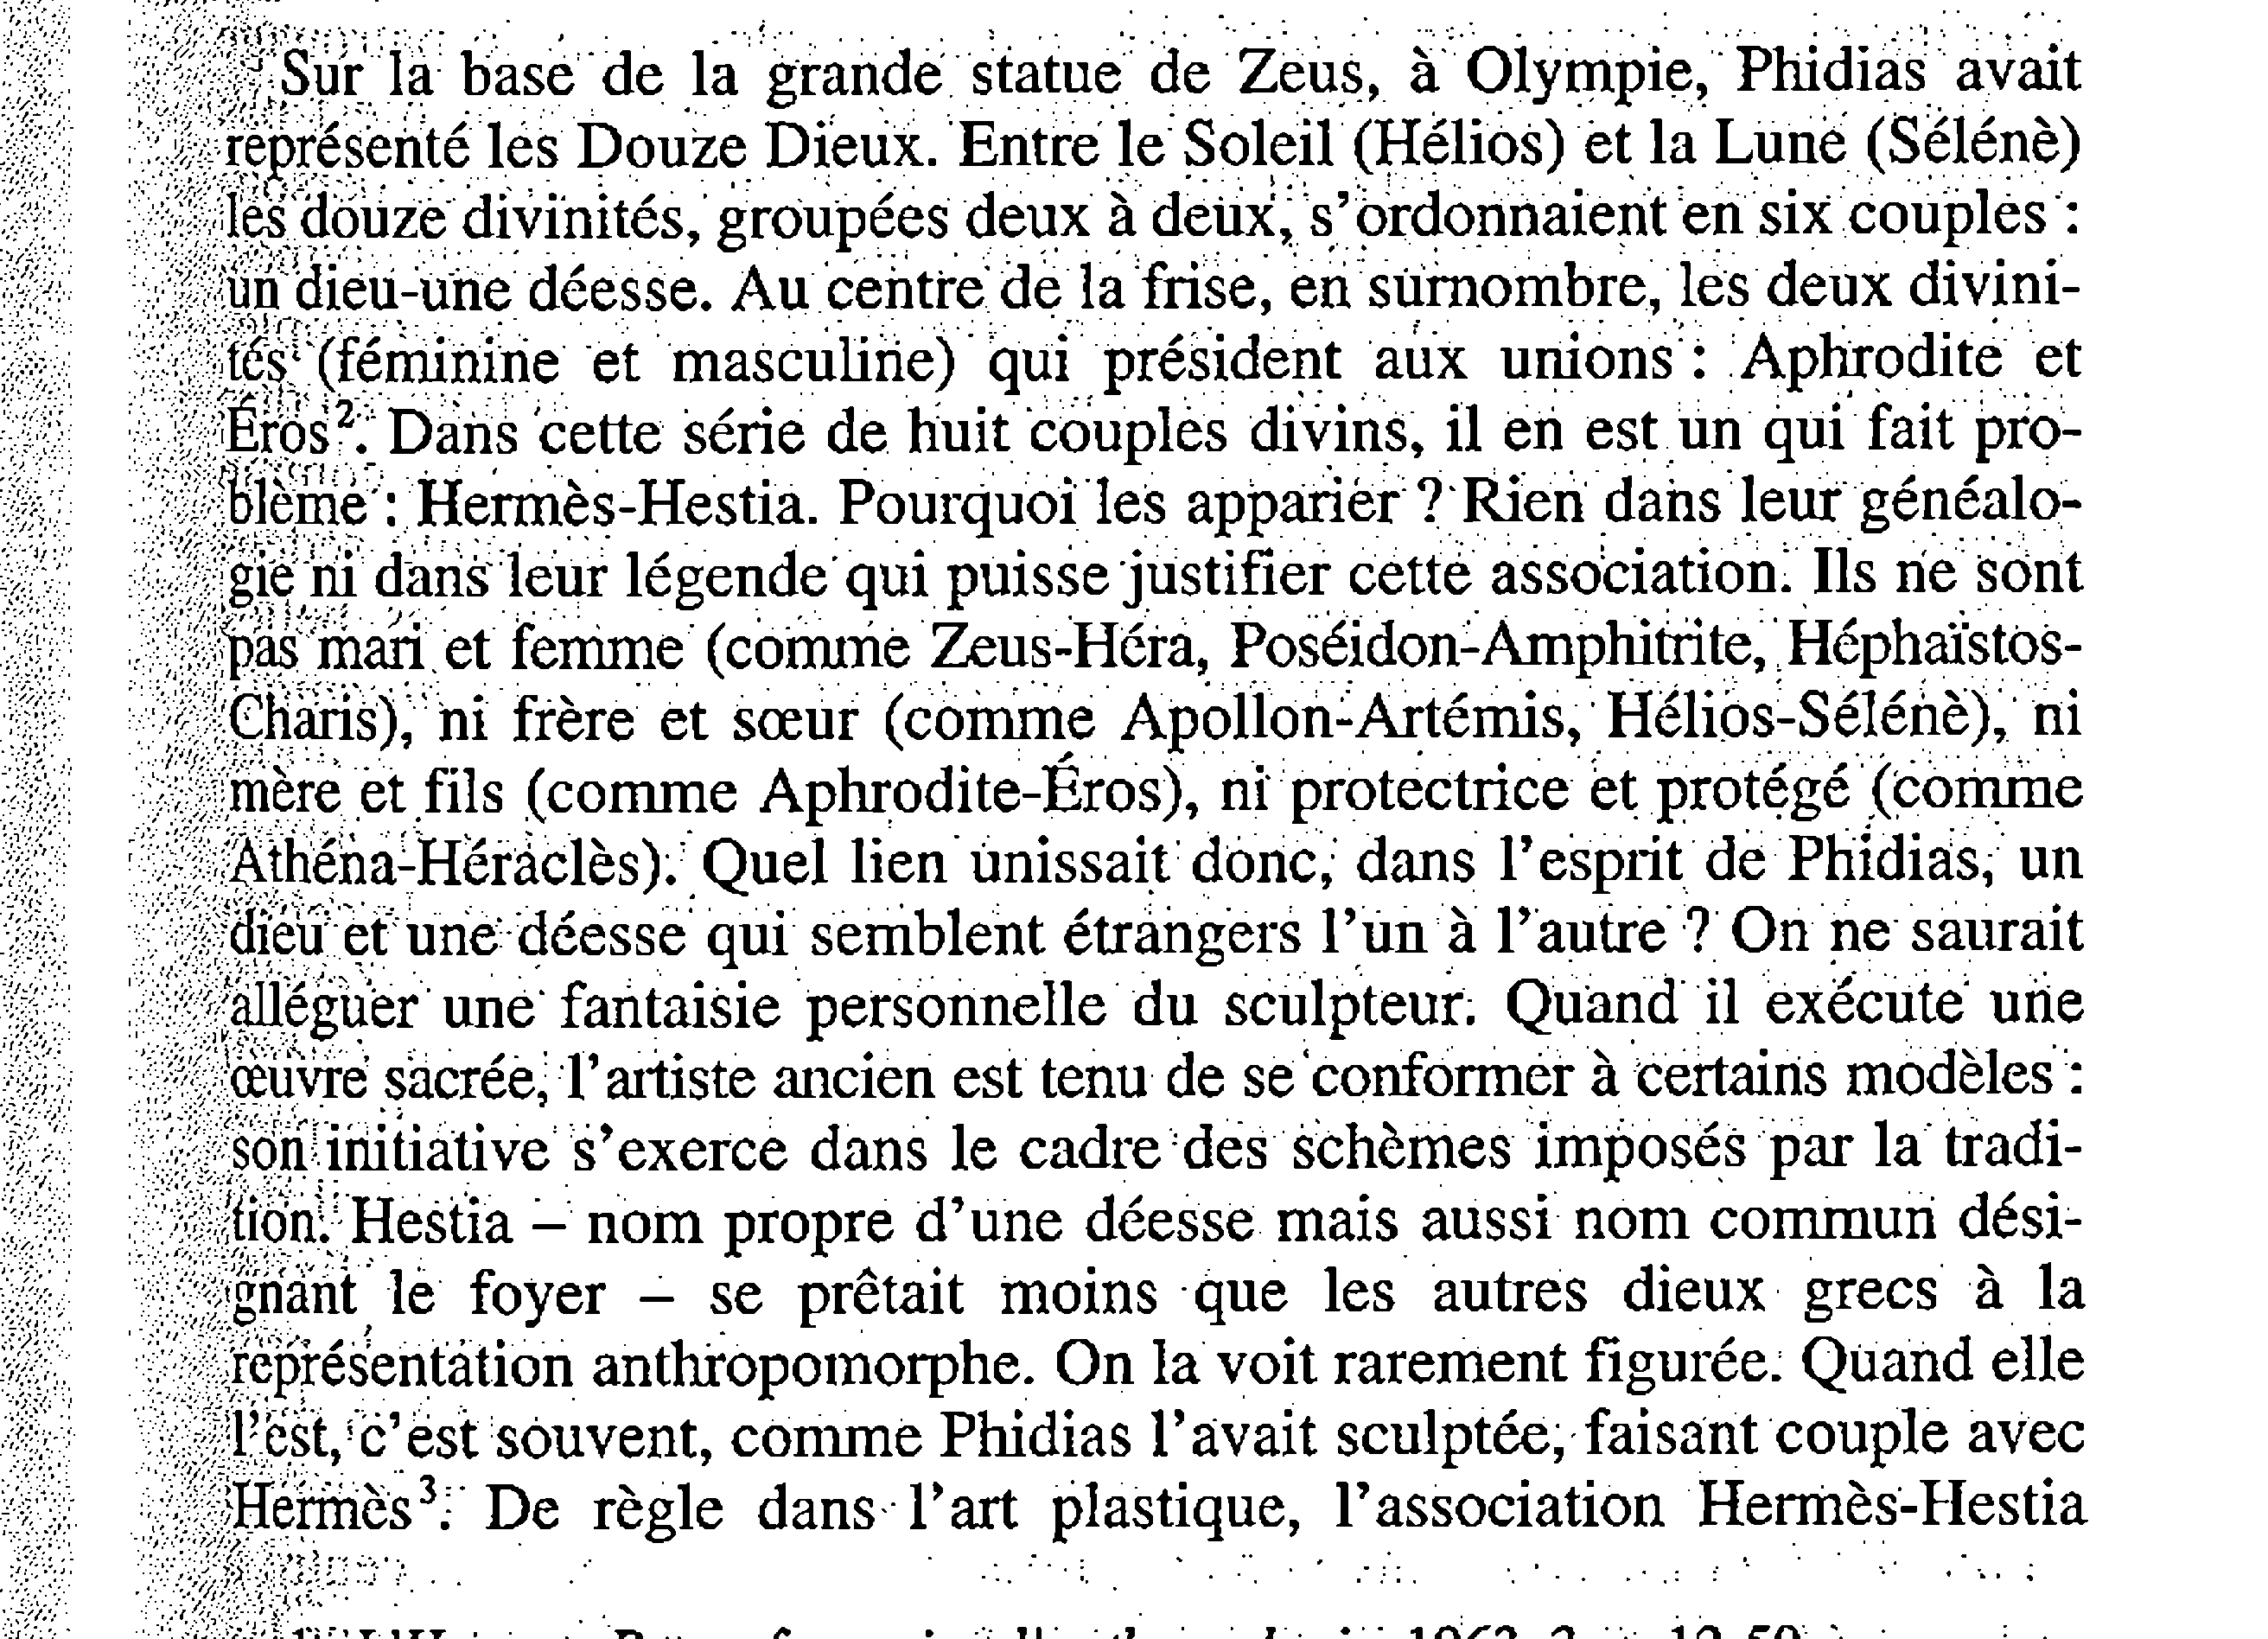

Remove small objects: file:/usr/local/lib/python3.6/dist-packages/sparkocr/resources/ocr/images/noised.png
Image:
        origin: file:/usr/local/lib/python3.6/dist-packages/sparkocr/resources/ocr/images/noised.png 
        width: 2624
        height: 1896
        mode: 10


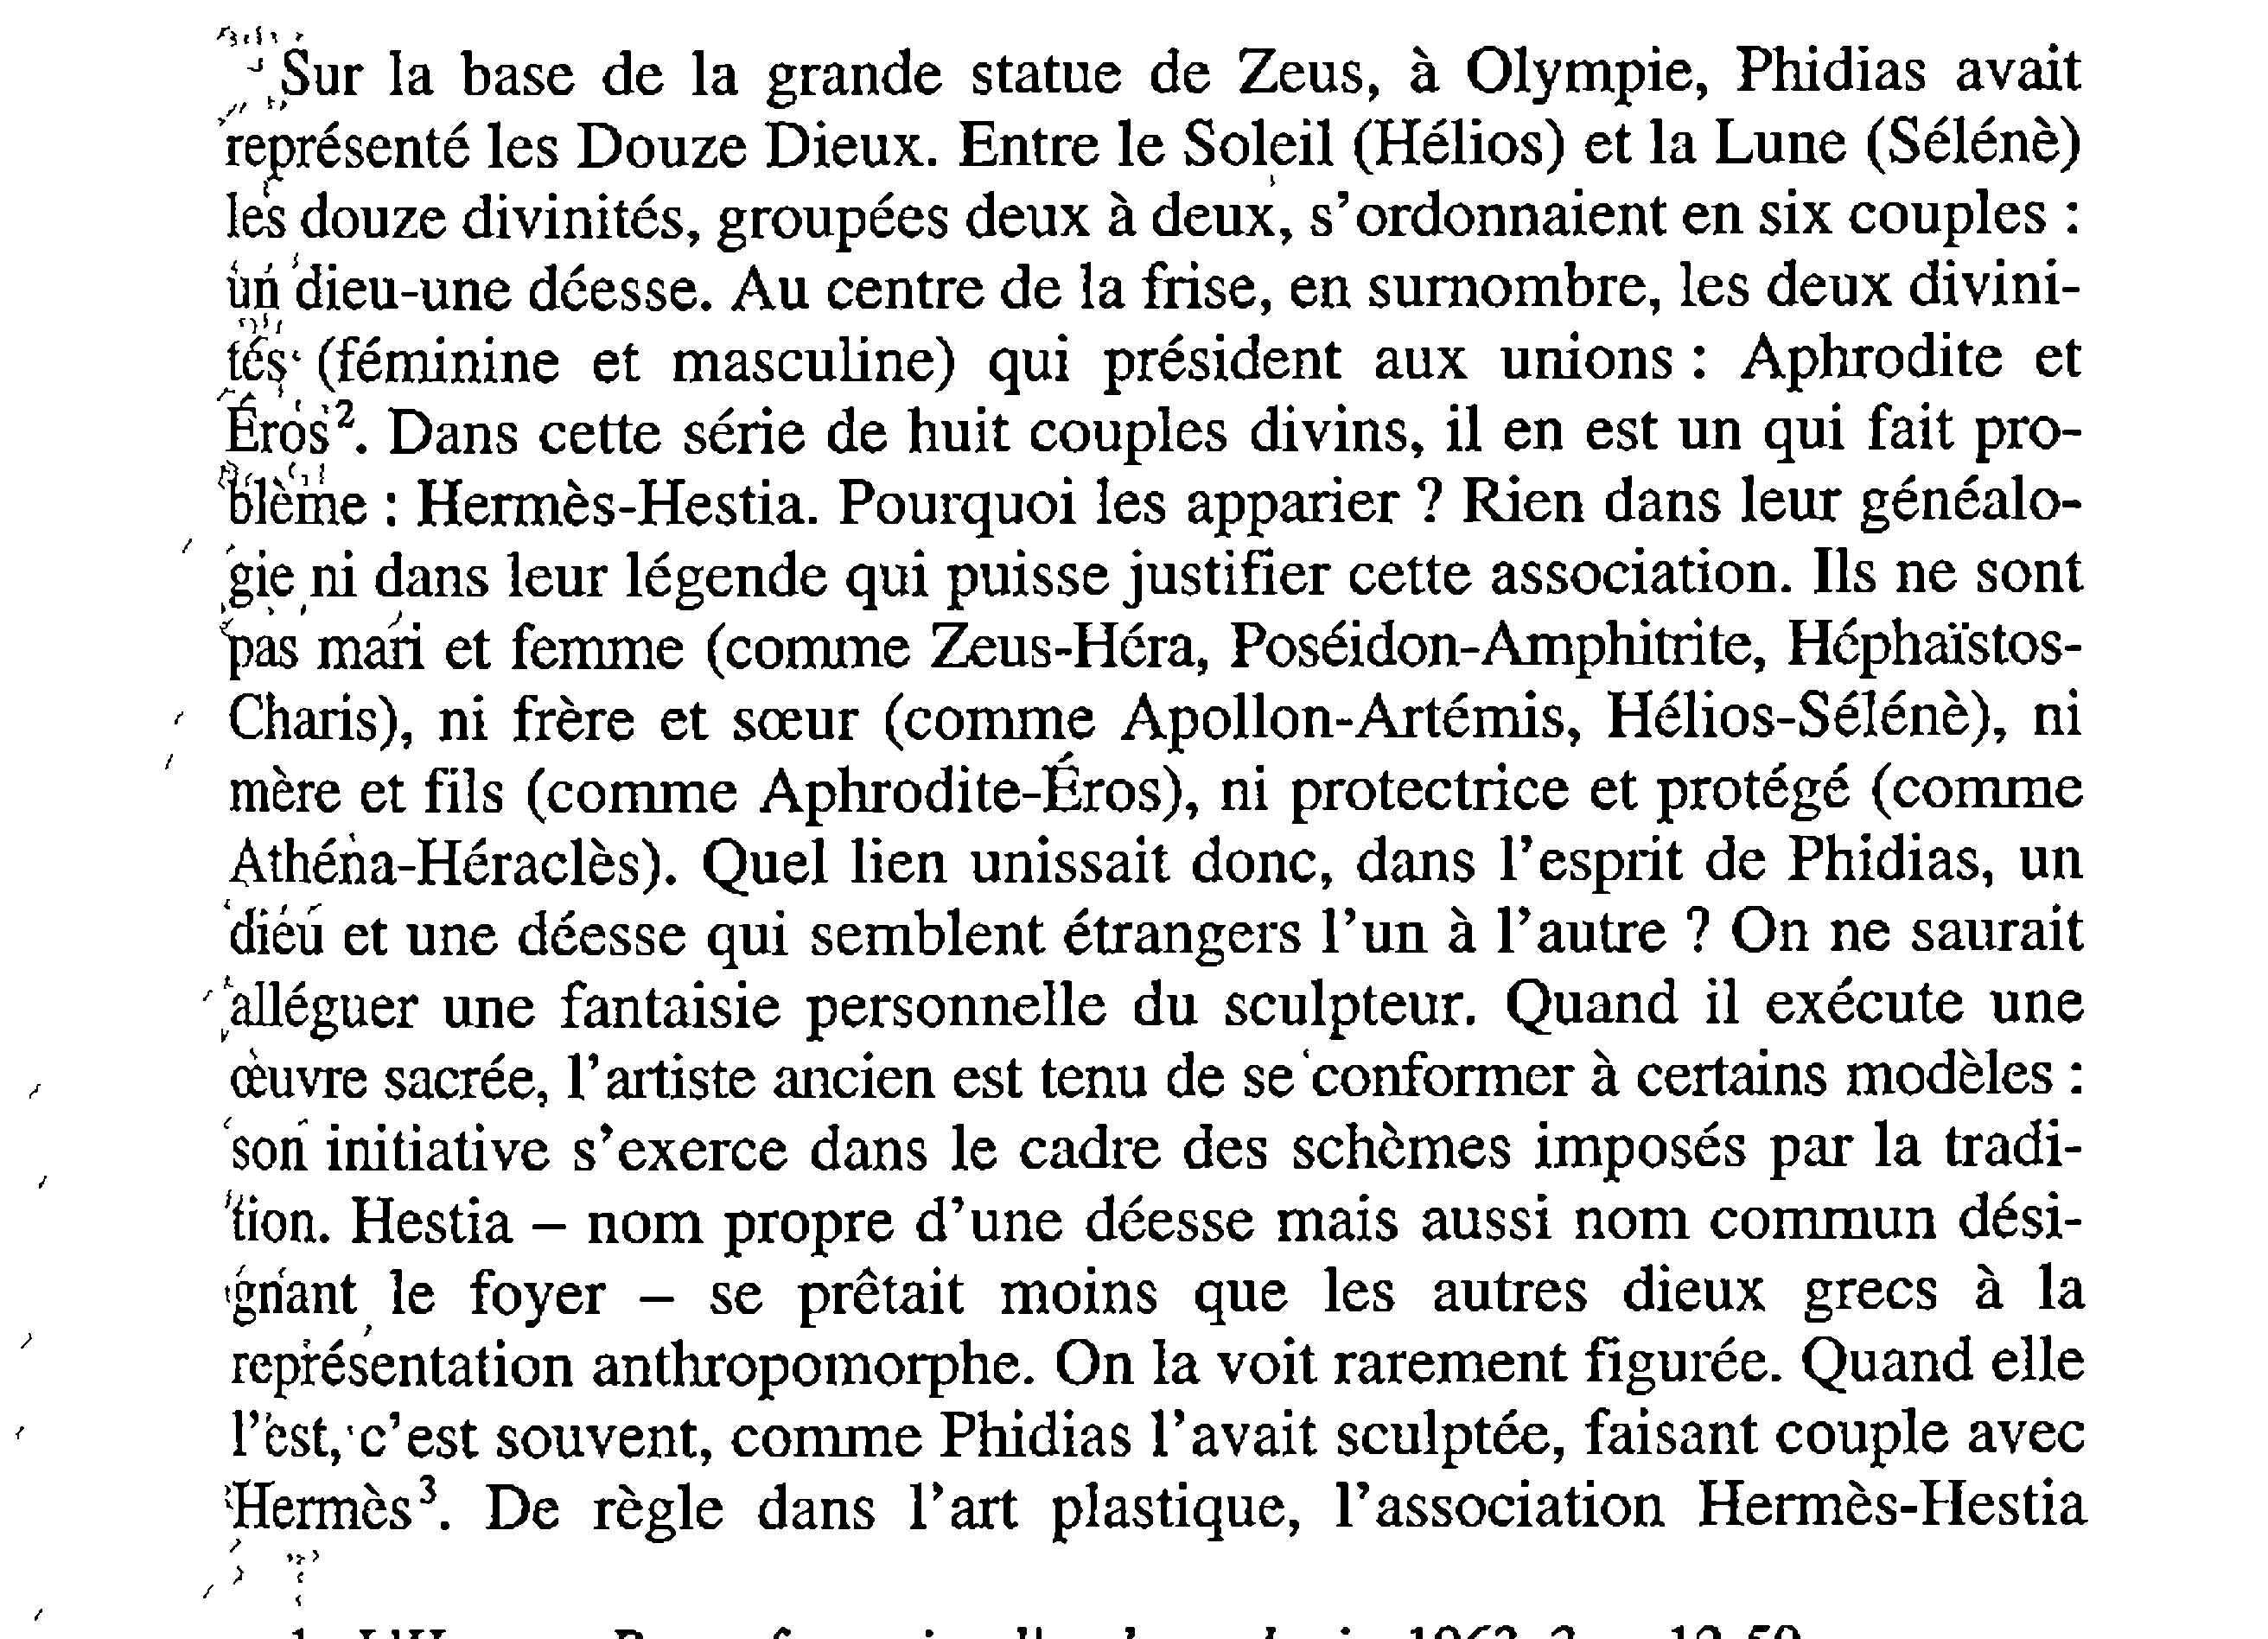

In [ ]:
for r in result.distinct().collect():
    print("Original: %s" % r.path)
    display_image(r.image)
    print("Binarized: %s" % r.path)
    display_image(r.binarized_image)
    print("Morphology opening: %s" % r.path)
    display_image(r.opening_image)
    print("Remove small objects: %s" % r.path)
    display_image(r.corrected_image)

## 6. Convert results to images and save

In [ ]:
for r in result.distinct().collect():

    img = to_pil_image(r.image, r.image.mode)
    img.save('img_grey.jpg')

    img = to_pil_image(r.binarized_image, r.binarized_image.mode)
    img.save('img_binarized.jpg')

    img = to_pil_image(r.opening_image, r.opening_image.mode)
    img.save('img_opening.jpg')
    
    img = to_pil_image(r.corrected_image, r.corrected_image.mode)
    img.save('img_corrected.jpg')


## 7. Compute score and compare it with ABBYY FineReader and AWS TextRact results

In [ ]:
# text recognized by ABBYY FineReader
abbyy_finereader = """Sur la base de la grande statue de Zeus, à Olympie, Phidias avait
présenté les Douze Dieux. Entre le Soleil (Hélios) et la Lune (Sëlénè)
& douze divinités, groupées deux à deux, s’ordonnaient en six couples :
n dieu-une déesse. Au centre de la frise, en surnombre, les deux divini-
(féminine et masculine) qui président aux unions : Aphrodite et
ms2;; Dans cette série de huit couples divins, il en est un qui fait prolemé : Hermès-Hestia. Pourquoi les apparier ? Rien dans leur généaloJfêfriï dans leur légende qui puisse justifier cette association: Ils rie sont
M m ari et femme (comme Zeus-Héra, Poséidon-Amphitrite, HéphaïstosÊHaris), ni frère et sœur (comme Apollon-Artémis, Hélios-Sélériè), ni
mère et fils (comme Aphrodite-Eros), ni protectrice et protégé (comme
théna Héraclès). Quel lien unissait donc, dans T esprit de Phidias, un
lieu et une dée s s e qui semblent étrangers l’un à l’autre ? On ne saurait
‘"eguer une fantaisie personnelle du sculpteur. Quand il exécuté une
livre sacrée, T artiste ancien est tenu de se conformer à certains modèles :
|®ihitiative s’exerce dans le cadre des schèmes imposes par la tradiipnV Hestia - nom propre d’une déesse mais aussi nom commun désignant le foyer - se prêtait moins que les autres dieux grecs à la
èprésentation anthropomorphe. On la voit rarement figurée. Quand elle
’est,5c’est souvent, comme Phidias l’avait sculptée, faisant couple avec
érmës3. De règle dans l’art plastique, l’association Hermès-Hestia
RpvÆ îi. -4'i 1 T l T i A r o a -i a """

# text recognized by AWS TextRact
text_ract = """Sur la base de la grande statue de Zeus, a Olympie, Phidias avait
represente les Douze Dieux. Entre le Soleil (Helios) et la Lune (Selene)
les douze divinites, groupees deux a deuix, s ordonnaient en six couples :
un dieu-une deesse. Au centre de la frise, en surnombre, les deux divini-
tes (feminine et masculine) que president aux unions : Aphrodite et
Eros?. Dans cette serie de huit couples divins, il en est un qui fait pro-
bleme': Hermes-Hestia. Pourquoi les apparier ? Rien dans leur genealo-
gre nI dans leur legende qui puisse justifier cette association. Ils ne sont
pas mari et femme (comme Zeus-Hera, Poseidon-Amphitrite, Hephaistos-
Charis), ni frere et soeur (comme Apollon-Artemis, Helios-Selene), ni
mere et fils (comme Aphrodite-Eros), ni protectrice et protege (comme
Athena-Heracles): Quel lien unissait donc, dans l'esprit de Phidias; un
dieu et une deesse qui semblent etrangers 'un a 1'autre ? On ne saurait
alleguer une fantaisie personnelle du sculpteur: Quand il execute une
ceuvre sacree, T'artiste ancien est tenu de se conformer a certains modeles :
son initiative 'exerce dans le cadre des schemes imposes par la tradi-
tion. Hestia - nom propre d'une deesse mais aussi nom commun desi-
gnant le foyer - se pretait moins que les autres dieux grecs a la
representation anthropomorphe. On la voit rarement figuree. Quand elle
Pest, c est souvent, comme Phidias 'avait sculptee, faisant couple avec
Hermes3 De regle dans l'art plastique, I'association Hermes-Hestia
TYy,,"""

In [ ]:
detected = "\n".join([row.text for row in result.collect()])

# Read original text
origin_text_file = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/noised.txt')
origin_text = open(origin_text_file, "r").read()

# Compute scores
abbyy_score = score(origin_text, abbyy_finereader)
textract_score = score(origin_text, text_ract)
corrected_score = score(origin_text, detected)

print("Abbyy FineReader score: {0}".format(abbyy_score))
print("Text Ract score: {0}".format(textract_score))
print("Score Spark NLP: {0}".format(corrected_score))

Abbyy FineReader score: 0.9016338779593197
Text Ract score: 0.9300769488123117
Score Spark NLP: 0.9528552456839309
